In [1]:
import numpy as np 
import pandas as pd 
import time 
import timeit 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import linregress
from itertools import combinations, permutations

In [2]:
dataset = pd.read_csv("dati_MM1.csv") #tanto vale andare di ordine 2
display(dataset) #non contiene i trigger che ormai non ci servono più (abbiamo il time pedestal e tutto)

,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER,EVENT,TIME_PEDESTAL,DRIFT_TIME,X,COLUMN
0,13.0,1.897417e+09,445.0,24.0,11145.000000,3.0,4.0,1.0,11350.0,205.000000,11.038462,4
1,14.0,1.897417e+09,450.0,9.0,11257.500000,3.0,2.0,1.0,11350.0,92.500000,4.980769,4
2,16.0,1.897417e+09,452.0,17.0,11314.166667,3.0,1.0,1.0,11350.0,35.833333,1.929487,4
3,15.0,1.897417e+09,458.0,9.0,11457.500000,3.0,3.0,1.0,11350.0,107.500000,5.788462,4
4,89.0,1.897417e+09,300.0,27.0,7522.500000,2.0,4.0,1.0,7825.0,302.500000,16.288462,7
...,...,...,...,...,...,...,...,...,...,...,...,...
114079,19.0,1.920940e+09,1449.0,2.0,36226.666667,3.0,3.0,1.0,36075.0,151.666667,8.166667,5
114080,55.0,1.920940e+09,325.0,4.0,8128.333333,3.0,3.0,1.0,8225.0,96.666667,5.205128,14
114081,56.0,1.920940e+09,327.0,22.0,8193.333333,3.0,1.0,1.0,8225.0,31.666667,1.705128,14
114082,54.0,1.920940e+09,331.0,20.0,8291.666667,3.0,2.0,1.0,8225.0,66.666667,3.589744,14


se ho X, COLUMN e LAYER posso costruire XR e XL come column +- x in un modo layer dependent; questo significa che tutte le altre colonne del dataframe non mi servono più e pertanto me ne sbarazzo (ma in modo "safe", cioè con una copia del dataset). Devo tenere orbit ed event perché mi aiutano ad identificare l'appartenenza di un dato hit ad un dato evento; infine aggiungo le colonne che riempirò a breve per indicare la posizione assoluta con ambiguità non risolta.

In [3]:
df = dataset.copy() 
df = df[["ORBIT_CNT","LAYER","EVENT","X","COLUMN"]]#tengo orbit, event, layer, column, x riassegnando a df se stesso a cui accedo mediante la lista delle colonne di interesse
df["XR"] = np.nan
df["XL"] = np.nan
display(df)
#df.info(memory_usage="deep") #4.4 mb

,ORBIT_CNT,LAYER,EVENT,X,COLUMN,XR,XL
0,1.897417e+09,4.0,1.0,11.038462,4,NaN,NaN
1,1.897417e+09,2.0,1.0,4.980769,4,NaN,NaN
2,1.897417e+09,1.0,1.0,1.929487,4,NaN,NaN
3,1.897417e+09,3.0,1.0,5.788462,4,NaN,NaN
4,1.897417e+09,4.0,1.0,16.288462,7,NaN,NaN
...,...,...,...,...,...,...,...
114079,1.920940e+09,3.0,1.0,8.166667,5,NaN,NaN
114080,1.920940e+09,3.0,1.0,5.205128,14,NaN,NaN
114081,1.920940e+09,1.0,1.0,1.705128,14,NaN,NaN
114082,1.920940e+09,2.0,1.0,3.589744,14,NaN,NaN


Adesso devo calcolare XR e XL, cioè le colonne contenenti le posizioni in coordinate assolute a partire da "in basso a sinistra" in mm (con ambiguità). Questo calcolo era già stato fatto (ma senza salvarne il risultato) dentro la funzione di disegno nel notebook precedente; mi basta allora riciclare parti di quel codice.

In [4]:
def compute_xr_xl(hit) :
    dx = 42 #lunghezza di un rettangolo in mm
    # mi serve per scalare le dimensioni da unità arbitrarie finora utilizzate in unità fisiche 

    #anche stavolta le serie danno problemi, gli array di numpy no!
    if hit.LAYER.to_numpy(dtype=int) % 2 != 0 : #mi viene meglio fare prima il caso senza traslazione
            hit["XR"] = dx * (hit.COLUMN - 1/2) + hit.X #stessa formula di prima +- X
            hit["XL"] = dx * (hit.COLUMN - 1/2) - hit.X
    else :
        hit["XR"] = dx * hit.COLUMN + hit.X #qui devo sommare dx/2 per tenere conto della traslazione dei layer 2 e 4 (nella nostra convenzione), quindi il -1/2 di prima si semplifica 
        hit["XL"] = dx * hit.COLUMN - hit.X 
    return hit

df = df.groupby(["ORBIT_CNT","EVENT","LAYER"],group_keys=False).apply(compute_xr_xl) #fissare orbit ed event mi dà ~4 hits; siccome abbiamo eliminato tempo fa le hits con più celle attive sullo stesso layer se raggruppo anche per layer posso stare certo di trovare un'unica hit da utilizzare nella funzione di cui sopra
# a questo punto però visto che l'intento è di applicare la funzione hit per hit potrei applicarla direttamente al dataframe intero 
display(df)

,ORBIT_CNT,LAYER,EVENT,X,COLUMN,XR,XL
0,1.897417e+09,4.0,1.0,11.038462,4,179.038462,156.961538
1,1.897417e+09,2.0,1.0,4.980769,4,172.980769,163.019231
2,1.897417e+09,1.0,1.0,1.929487,4,148.929487,145.070513
3,1.897417e+09,3.0,1.0,5.788462,4,152.788462,141.211538
4,1.897417e+09,4.0,1.0,16.288462,7,310.288462,277.711538
...,...,...,...,...,...,...,...
114079,1.920940e+09,3.0,1.0,8.166667,5,197.166667,180.833333
114080,1.920940e+09,3.0,1.0,5.205128,14,572.205128,561.794872
114081,1.920940e+09,1.0,1.0,1.705128,14,568.705128,565.294872
114082,1.920940e+09,2.0,1.0,3.589744,14,591.589744,584.410256


Per potere effettuare un fit mi serve anche il valore di Y (che è lo stesso per XR e XL). Per calcolarlo basta usare la stessa formula usata nella funzione per graficare il detector nel time pedestal, che dipende solo dal valore del layer

In [5]:
dy = 13 #altezza singolo rettangolo in mm
df["Y"] = dy * (df.LAYER-1/2)
display(df)

,ORBIT_CNT,LAYER,EVENT,X,COLUMN,XR,XL,Y
0,1.897417e+09,4.0,1.0,11.038462,4,179.038462,156.961538,45.5
1,1.897417e+09,2.0,1.0,4.980769,4,172.980769,163.019231,19.5
2,1.897417e+09,1.0,1.0,1.929487,4,148.929487,145.070513,6.5
3,1.897417e+09,3.0,1.0,5.788462,4,152.788462,141.211538,32.5
4,1.897417e+09,4.0,1.0,16.288462,7,310.288462,277.711538,45.5
...,...,...,...,...,...,...,...,...
114079,1.920940e+09,3.0,1.0,8.166667,5,197.166667,180.833333,32.5
114080,1.920940e+09,3.0,1.0,5.205128,14,572.205128,561.794872,32.5
114081,1.920940e+09,1.0,1.0,1.705128,14,568.705128,565.294872,6.5
114082,1.920940e+09,2.0,1.0,3.589744,14,591.589744,584.410256,19.5


Adesso arriva il bello!! 
Supponiamo di avere un evento dotato di 4 hits (una per layer) per un totale di 8 punti candidati a costruire la nostra retta. Per ciascun livello dobbiamo scegliere un punto; dal momento che abbiamo due punti da scegliere da ciascun layer e 4 layer in totale questo significa che abbiamo 2^4=16 possibili combinazioni di punti. Se l'evento "funziona" una di queste combinazioni produrrà una retta che attraverserà in pieno TUTTI i punti con cui è stata costruita anziché solo alcuni; poiché ci sono degli errori sperimentali sui drift_times e quindi sulle XR/XL non possiamo aspettarci che la retta "giusta" attraversi esattamente i punti "giusti", quindi dobbiamo piuttosto cercare la retta di best fit che minimizza la distanza fra i punti e la retta di best fit stessa.  
Volendo lavorare a forza bruta possiamo procedere così: 
- mediante meshgrid, transpose e reshape costruiamo in modo molto efficiente le 16 possibili combinazioni menzionate sopra. Come/perché questo funzioni è un po' difficile da spiegare; alla fine ci sono delle celle che ho usato per fare dei test che dovrebbero contenere un abbozzo di spiegazione, ma per il momento mi mantengo sul vago. L'alternativa è usare itertools.combinations, che pur essendo molto più intuitivo pare sia non altrettanto performante e mealleabile ai nostri scopi.
- per ciascuna di queste 16 combinazioni calcoliamo la retta di best fit mediante scipy.stats.linregress(); pare che questa sia la funzione che non ci richieda di costruire esplicitamente una matrice da invertire più veloce per effettuare la regressione lineare (stando a [questo articolo](https://www.freecodecamp.org/news/data-science-with-python-8-ways-to-do-linear-regression-and-measure-their-speed-b5577d75f8b/), perlomeno). Per misurare quella che si adatta meglio guardiamo al coefficiente di correlazione lineare r e scegliamo quella con r massimo; poiché non mi va di sprecare memoria per rette quasi tutte da buttare penso sia una buona idea tenere traccia della retta migliore e ogni volta confrontare con la successiva e scartare la retta sconfitta (si possono provare alternative, comunque. Magari salvandole e poi massimizzando r viene meglio, boh). Chiaramente oltre alla retta migliore salviamo quale combinazione di punti l'abbia prodotta!
- in linea di principio fatto questo lavoro dobbiamo controllare quale sia la massima distanza orizzontale di un qualunque punto selezionato dalla retta stessa. Sappiamo che nel caso di eventi buoni tale distanza è minore dell'incertezza sperimentale data da v_drift*25 ns; se questa condizione non si verifica vuol dire che la misura in questione non è compatibile con una traiettoria rettilinea che attraversi tutti i punti osservati (entro l'incertezza sperimentale) in nessun caso, e quindi l'evento va scartato.  
  
Ovviamente l'approccio di cui sopra è a forza bruta e probabilmente come prestazioni fa schifo, quindi mi limito a lavorare per il momento con un mini dataframe se non altro per arrivare a qualche risultato; oltre a scrivere le cose in modo più efficiente ha senso pensare ad un algoritmo che non abbia bisogno di costruire tutte e 16 le rette. Come detto la costruzione di tutte le coppie possibili mediante meshgrid è molto veloce, quindi è ragionevole aspettarsi che il grosso del tempo venga impiegato dai fit e dai confronti; per questo è desiderabile adottare una strategia più furba. Per ora vado a forza bruta incrociando le dita  


In [6]:
# Esempio non calzante quando in una stessa orbit vi sono più eventi, qui infatti utilizzo come discriminante per ogni evento l'orbita e non il raggruppamento a cipolla anche per "event"

df_mini = df[df.ORBIT_CNT == df.ORBIT_CNT.unique()[0]]
display(df_mini)


,ORBIT_CNT,LAYER,EVENT,X,COLUMN,XR,XL,Y
0,1.897417e+09,4.0,1.0,11.038462,4,179.038462,156.961538,45.5
1,1.897417e+09,2.0,1.0,4.980769,4,172.980769,163.019231,19.5
2,1.897417e+09,1.0,1.0,1.929487,4,148.929487,145.070513,6.5
3,1.897417e+09,3.0,1.0,5.788462,4,152.788462,141.211538,32.5


In [7]:
from itertools import product 
comb = np.array(list(product(*df_mini.loc[:, ['XR', 'XL']].to_numpy())))
Y = np.array(df_mini['Y'].to_numpy())
r = np.zeros(comb.shape[0]) # voglio sedici coefficienti di correlazione lineare tra i quali soltanto uno sarà scelto per rappresentare la più appetibile retta dell'evento fisico analizzato
for i in range(comb.shape[0]):
    r[i] = np.corrcoef(comb[i], Y)[0,1]
best = comb[np.abs(r).argmax()]

## utilizzo il fatto che gli array come escono sono ordinati e anzichè layer1234 metto solo una colonna che chiamo x vincitore in cui hit per hit vi andrà il punto che vince per coefficiente di correlazione lineare
df_mini.loc[:,'X_BEST']=best
df_mini

,ORBIT_CNT,LAYER,EVENT,X,COLUMN,XR,XL,Y,X_BEST
0,1.897417e+09,4.0,1.0,11.038462,4,179.038462,156.961538,45.5,179.038462
1,1.897417e+09,2.0,1.0,4.980769,4,172.980769,163.019231,19.5,163.019231
2,1.897417e+09,1.0,1.0,1.929487,4,148.929487,145.070513,6.5,145.070513
3,1.897417e+09,3.0,1.0,5.788462,4,152.788462,141.211538,32.5,152.788462


In [8]:
# dopo aver creato le colonne layer1-2-3-4 costruisco una funzione che assegna alla fine ad ognuna di queste per ciascun evento le ascisse x1-2-3-4 dei punti che raggiungono il miglior coefficiente di correlazione lineare
from itertools import product 
def plotline(group):
    Xs = np.array(list(product(*group.loc[:, ['XR','XL']].to_numpy())))
    Y = np.array(group['Y'].to_numpy())
    # X e Y devono essere rispettivamente: X l'array di quattro elementi che esce fuori da "vettore" mentre Y la colonna del dataframe corrispondente all'evento che stiamo analizzando
    if Xs.shape[1] != Y.shape[0] : # perchè Xs è un array 16 x 4 elementi e a me interessa che matchi con il numero di elementi di Y cioè teoricamente 4 (oppure entrambi tre quando ci dovessero essere dei buchi)
        print("X.shape and Y.shape don't match")
        return None 
    r = np.zeros(Xs.shape[0]) # voglio sedici coefficienti di correlazione lineare tra i quali soltanto uno sarà scelto per rappresentare la più appetibile retta dell'evento fisico analizzato
    for i in range(Xs.shape[0]) :
        r[i] = np.corrcoef(Xs[i],Y)[0,1] # perchè r[i] è una matrice 
    bestx = Xs[np.abs(r).argmax()]
    #print(Xs)
    # ho bisogno del dataframe ordinato per layer per assegnare i quattro punti a partire dalle componenti ordinate univocamente dell'array best 
    group.loc[:,'X_BEST']=bestx
    return group

In [9]:
df1 = df.groupby(['ORBIT_CNT','EVENT'], group_keys=False)\
                                       .apply(plotline)\
                                       .reset_index()\
                                       .drop(['index'],axis=1) 

In [12]:
# funzione che aggiunge le colonne M e Q al dataframe che rappresentano il coefficiente angolare e l'intercetta della retta di fit 
from scipy import stats
def meq(event):
    X = np.array(event['X_BEST'].to_numpy())
    Y = np.array(event['Y'].to_numpy())
    res = stats.linregress(X,Y)
    event['M'] = res.slope
    event['Q'] = res.intercept
    return event

In [13]:
df2 = df1.groupby(['ORBIT_CNT','EVENT'], group_keys=False)\
                                       .apply(meq)\
                                       .reset_index()\
                                       .drop(['index'],axis=1) 
df2

,ORBIT_CNT,LAYER,EVENT,X,COLUMN,XR,XL,Y,X_BEST,M,Q
0,1.897417e+09,4.0,1.0,11.038462,4,179.038462,156.961538,45.5,179.038462,0.921732,-121.457974
1,1.897417e+09,2.0,1.0,4.980769,4,172.980769,163.019231,19.5,163.019231,0.921732,-121.457974
2,1.897417e+09,1.0,1.0,1.929487,4,148.929487,145.070513,6.5,145.070513,0.921732,-121.457974
3,1.897417e+09,3.0,1.0,5.788462,4,152.788462,141.211538,32.5,152.788462,0.921732,-121.457974
4,1.897417e+09,4.0,1.0,16.288462,7,310.288462,277.711538,45.5,310.288462,0.662078,-161.453881
...,...,...,...,...,...,...,...,...,...,...,...
114079,1.920940e+09,3.0,1.0,8.166667,5,197.166667,180.833333,32.5,197.166667,0.940813,-161.987756
114080,1.920940e+09,3.0,1.0,5.205128,14,572.205128,561.794872,32.5,572.205128,0.954628,-527.043310
114081,1.920940e+09,1.0,1.0,1.705128,14,568.705128,565.294872,6.5,565.294872,0.954628,-527.043310
114082,1.920940e+09,2.0,1.0,3.589744,14,591.589744,584.410256,19.5,584.410256,0.954628,-527.043310


In [14]:
# adesso devo rappresentare le rette che ottengo tramite dei fit su quattro punti. 
delta_x = 42/(2*390)*(50) #l'indeterminazione sulle x è v_d*delta_t=42/(2*390)*(2*25). Calcolo questo valore fuori perché non ha senso ricalcolarlo volta per volta, è una costante

def event_plot(event):
    
    fig,ax1 = plt.subplots(figsize=(1.5*4.2*17,1.5*1.3*6))
    
    #dimensions of one cell
    dx = 42
    dy = 13
    
    #draw the detector
    ax1.set_xlim(0,42*16 + 42)
    ax1.set_ylim(-13,13*4 + 13)

    xr = np.array(event['XR'].to_numpy())
    xl = np.array(event['XL'].to_numpy())
    X = np.array(event['X_BEST'].to_numpy())
    Y = np.array(event['Y'].to_numpy())

    x_1 = x_3 = np.arange(16)*dx 
    x_2 = x_4 = x_1 + dx/2
    [y_1, y_2, y_3, y_4] = np.arange(4)*dy 


    for i in range(16):
        rect = patches.Rectangle((x_1[i],y_1),dx,dy,linewidth=10,edgecolor='black',facecolor='none')
        ax1.add_patch(rect)
    
        rect = patches.Rectangle((x_2[i],y_2),dx,dy,linewidth=10,edgecolor='black',facecolor='none')
        ax1.add_patch(rect)
    
        rect = patches.Rectangle((x_3[i],y_3),dx,dy,linewidth=10,edgecolor='black',facecolor='none')
        ax1.add_patch(rect)
        
        rect = patches.Rectangle((x_4[i],y_4),dx,dy,linewidth=10,edgecolor='black',facecolor='none')
        ax1.add_patch(rect)
        
        ax1.axis('off')
        
    ax1.scatter(xr,Y, marker = 'x', c = 'red', s = 500, linewidth = 7)
    ax1.scatter(xl,Y, marker = 'x', c = 'red', s = 500, linewidth = 7)
    ax1.errorbar(X, Y, xerr=delta_x, fmt='.', c = 'blue', linewidth = 7) # errorbar
    ax1.plot([(-2-event.Q)/event.M,(60-event.Q)/event.M] ,[-2,60], c= 'blue', linewidth = 7)
    # avendo visto che il massimo in altezza che raggiunge il detector è circa cinquanta, affinchè la retta cha rappresenta la traiettoria della particella sia visibile scelgo come limite superiore sessanta.
    return ax1


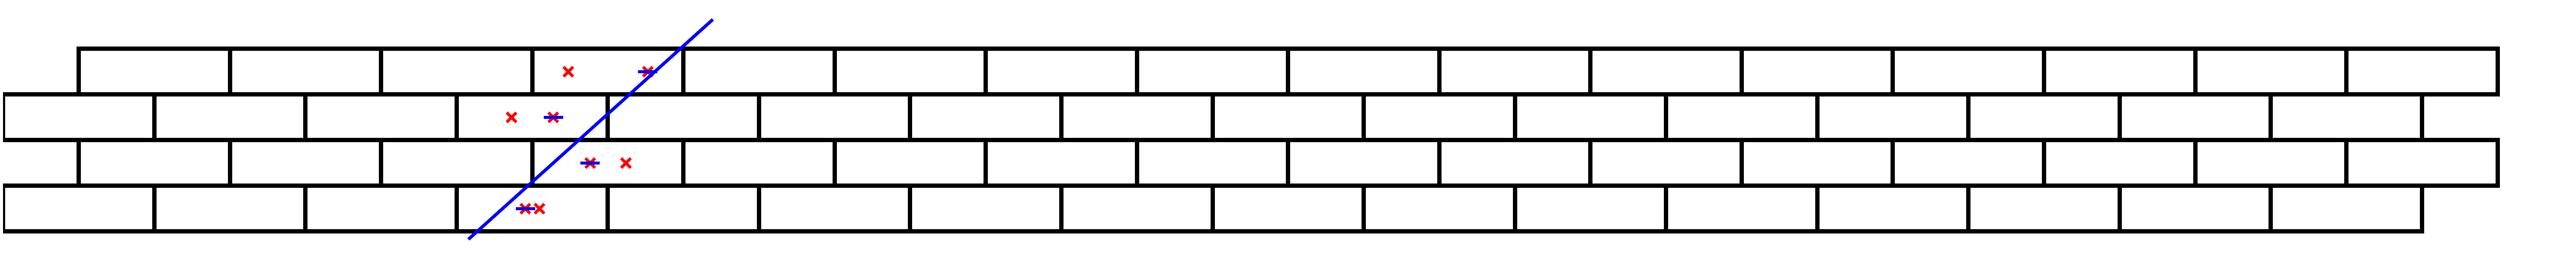

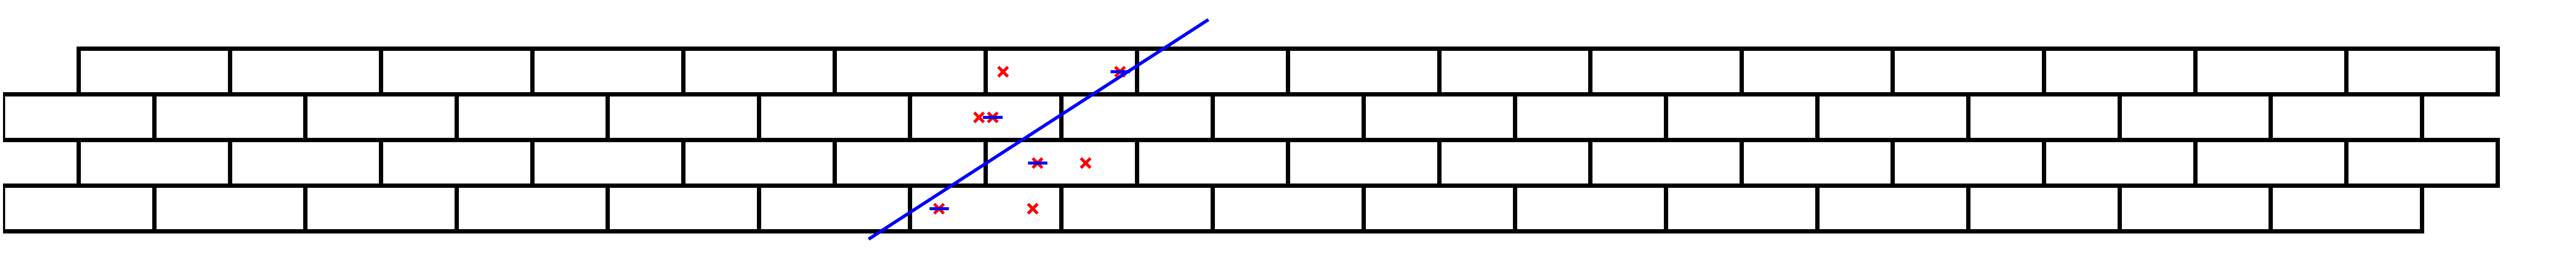

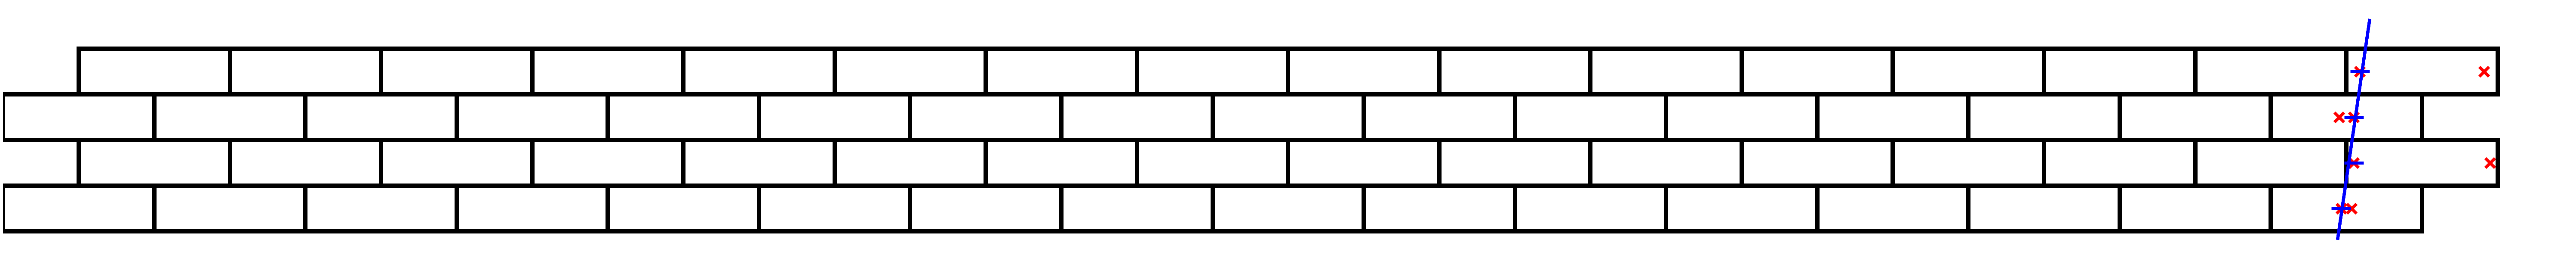

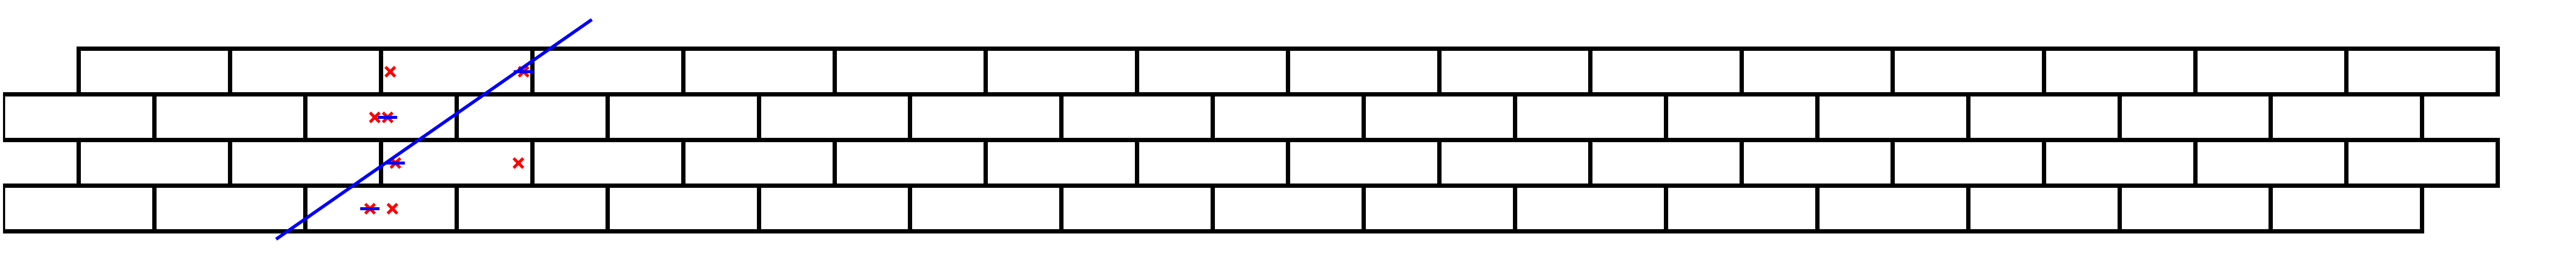

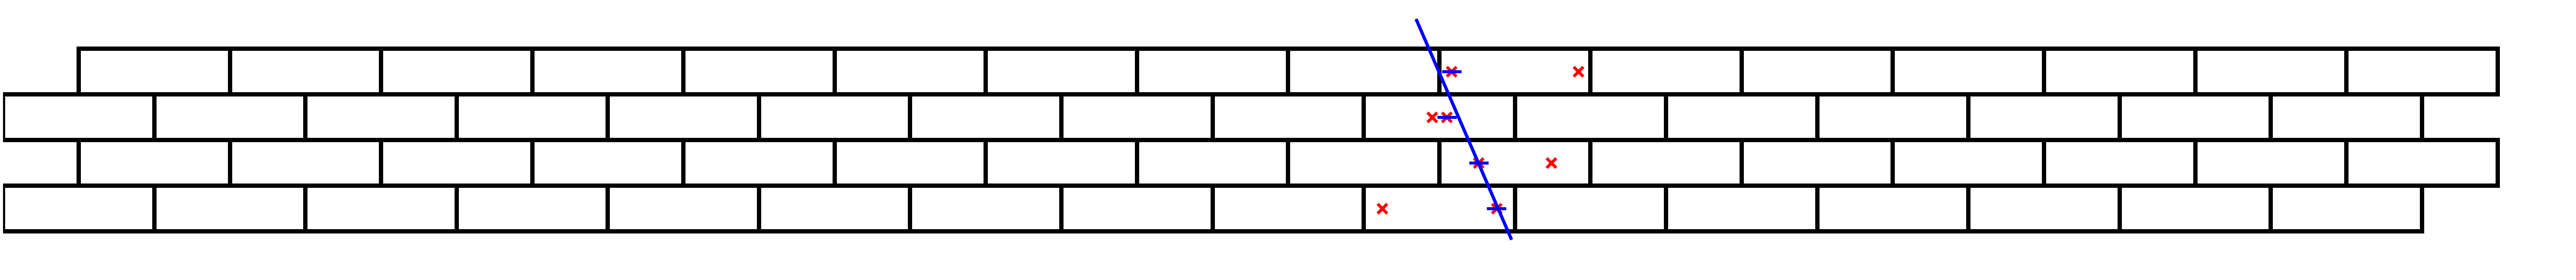

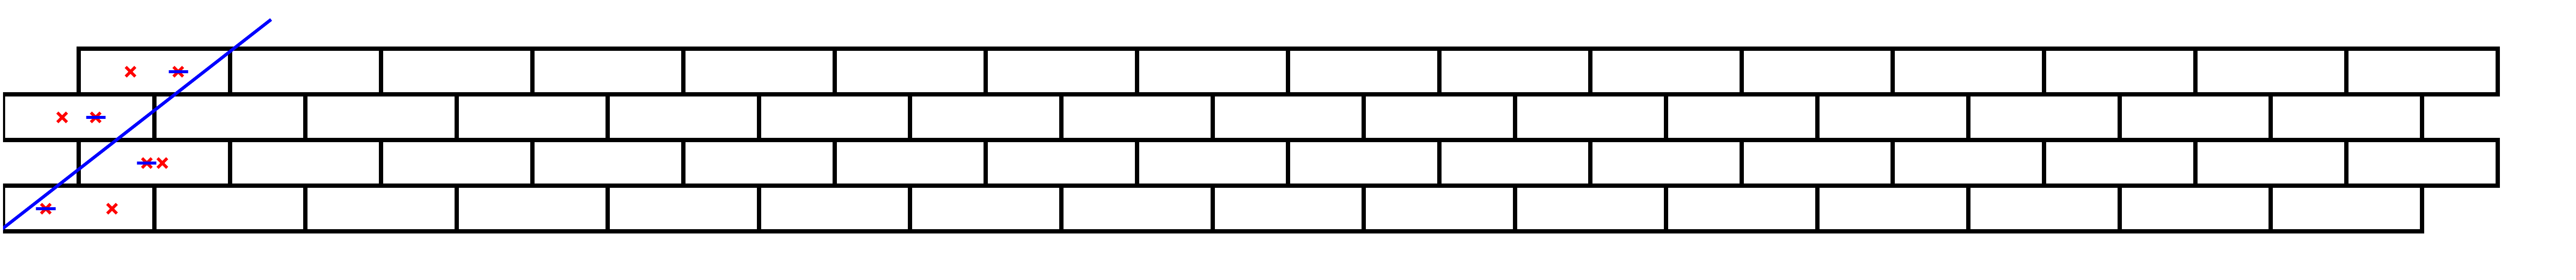

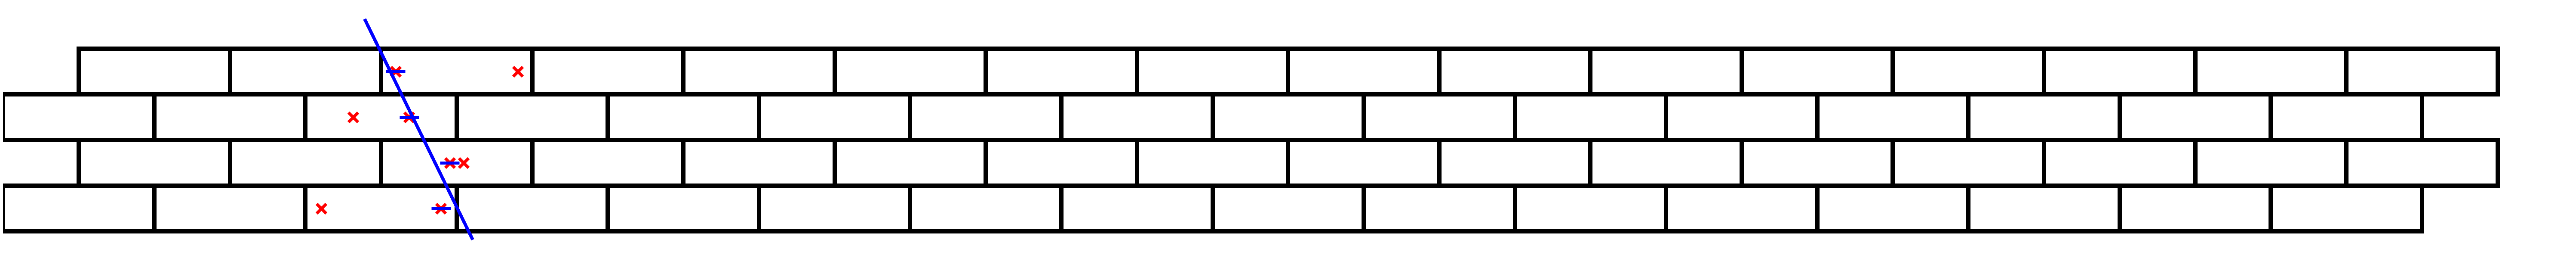

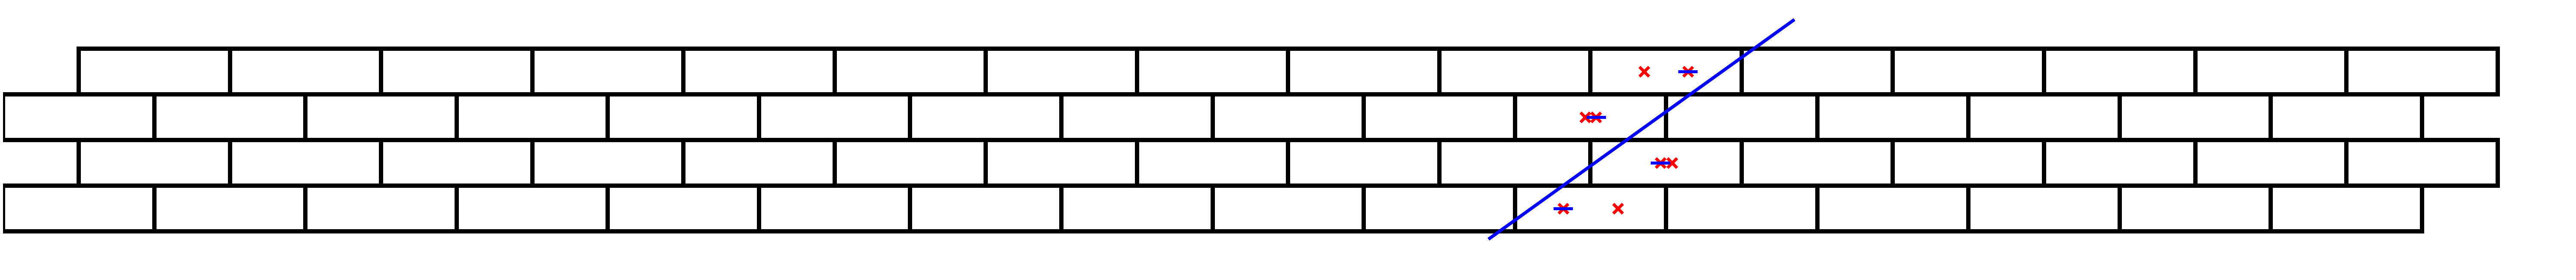

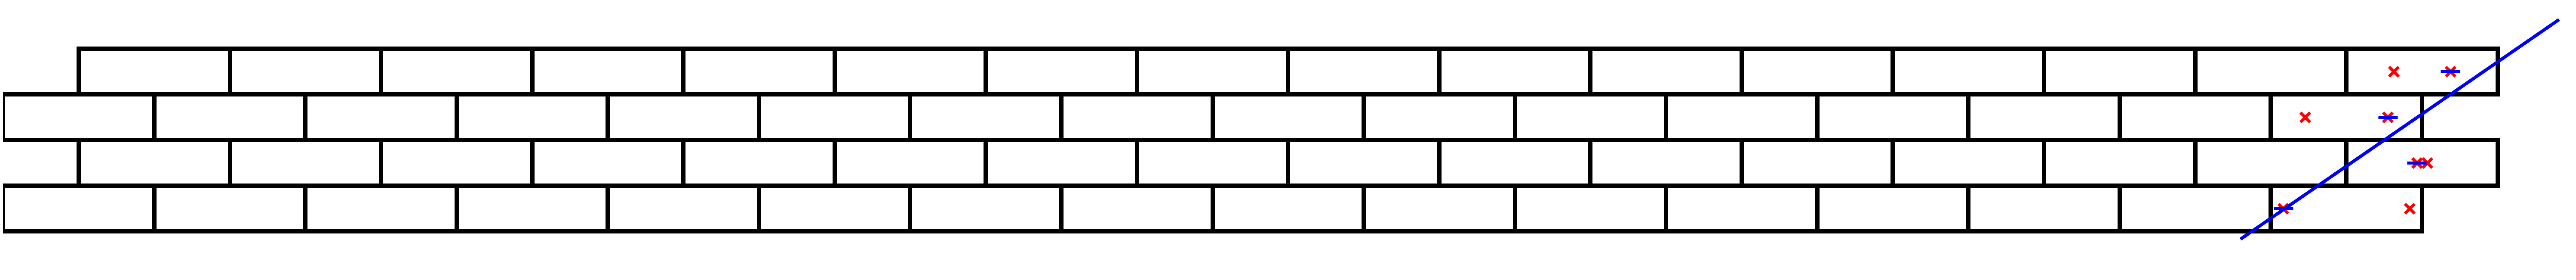

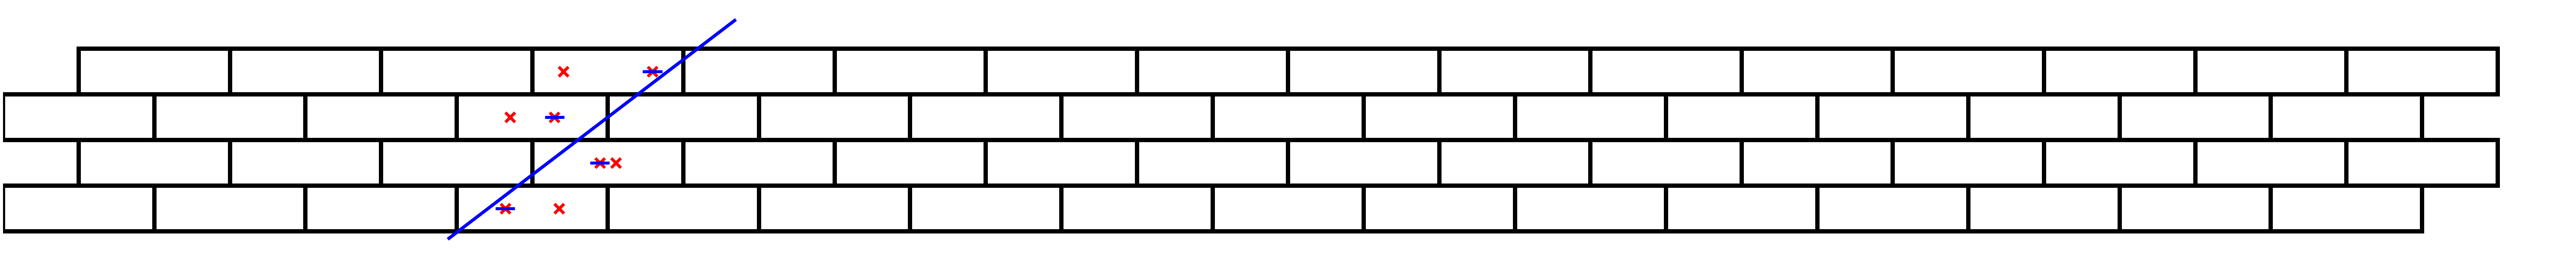

In [15]:
for i in np.unique(df2.ORBIT_CNT.values)[:10]:
    try:
        event = df2.groupby(['ORBIT_CNT','EVENT']).get_group((i,1))
        event_plot(event)
    except:
        event = df2.groupby(['ORBIT_CNT']).get_group(i)
        event_plot(event)

event = df2.groupby(['ORBIT_CNT','EVENT']).get_group((np.unique(df2.ORBIT_CNT.values)[10],1))
event.to_csv('event.csv', index=False)

Supponiamo di avere determinato le varie rette "vincitrici"; poiché la parte precedente non fa altro che prendere quella che meglio si adatta ai punti dobbiamo verificare se queste soluzioni siano accettabili, cioè in particolare se siano compatibili con il nostro errore sperimentale. Come già detto a causa dell'errore sui tempi non possiamo aspettarci che le rette attraversino esattamente i punti, però se lo scarto (cioè la distanza orizzontale dalla retta) supera il margine concesso dall'errore sperimentale l'evento va scartato in quanto incompatibile con l'errore e pertanto inaccettabile.   

Il problema da risolvere è quindi come calcolare la "distanza orizzontale" retta-punto - distanza che non è quella tradizionalmente definita mediante proiezione ortogonale/prodotto scalare, ma è piuttosto ottenuta proiettando parallelamente all'asse x (infatti l'indeterminazione riguarda le coordinate x, le uniche su cui il drift time calcolato/misurato restituisce informazione). Proiettando in questo modo individuiamo una retta parallela all'asse x e che interseca in un certo punto $P$ la retta ottenuta mediante regressione lineare; la distanza che cerchiamo è allora la differenza in modulo fra $x_i$ e $P$ - avendo indicato con $(x_i,y_i)$ il punto di partenza.  

Per trovare le coordinate del punto di intersezione fra la retta $y=y_i$ e la retta $y=mx+q$ basta imporre $y_i=mx_P+q$, da cui ottengo la formula $$d_x(P,(x_i,y_i)) = |x_i-x_P| = \Bigg|x_i-\frac{1}{m}(y_i-q)\Bigg| $$
Questa formula diverge per $m\to0 $, ma questo significa solo che siccome per $m=0$ le rette sono parallele queste si incontrano all'infinito - risultato corretto ma non rilevante, visto che noi non abbiamo mai traiettorie orizzontali fisicamente accettabili visto come è stato prodotto il fascio di muoni e vista la sensibilità fino a 45-50 gradi rispetto alla verticale del trigger.  
Se invece $m\to +\infty$ (traiettoria verticale) questa formula mi restituisce $d_x=x_i$ - risultato corretto, visto che quando $q$ è fissato ed $m$ diverge la nostra retta diventa l'asse y (ruota attorno all'intercetta fissata).  
Di conseguenza in tutti i casi di nostro interesse ($m\in\mathbb{R}\setminus\{0\}$, $q\in\mathbb{R}$) la formula di cui sopra restituisce il risultato voluto; in particolare dobbiamo calcolare questa $d_x$ per ogni punto associato ad un particolare evento, prendere la massima e imporre che non superi $v_d\Delta t$ (essendo $\Delta t$ l'incertezza sul drift time, cioè $\Delta t\approx 50 \ \text{ns}$).

In [16]:
# Experimental uncertainty compatibility check

def exp_unc_compatib_check(event): 
    if (np.abs((np.array(event['X_BEST'].to_numpy())) - ((np.array(event['Y'].to_numpy()))-(np.array(event['Q'].to_numpy())))/(np.array(event['M'].to_numpy())))).max() < delta_x : #questa espressione è già vettorizzata: la valuto contemporaneamente per tutte le hits (righe) di un evento e prendo il massimo
        return event #nota: siccome sono float due valori difficilmente saranno esattamente uguali, quindi anche se fisicamente è ragionevole qui non ha senso mettere <=, facciamo un confronto in più
    else : #mettere prima il caso in cui si tiene rispetto a quello in cui si scarta o viceversa non sono necessariamente alternative equivalenti! Infatti i dati sono stati ripuliti molto,
        return None  #quindi mi aspetto che i dati da scartare saranno una minoranza - e allora tanto vale mettere prima la condizione che viene soddisfatta quasi sempre senza bisogno di arrivare all'else.
        #poi ovviamente questo ansatz va messo alla prova..!

In [17]:
df3 = df2.groupby(['ORBIT_CNT','EVENT'], group_keys=False)\
                                       .apply(exp_unc_compatib_check)\
                                       .reset_index()\
                                       .drop(['index'],axis=1) 
df3

,ORBIT_CNT,LAYER,EVENT,X,COLUMN,XR,XL,Y,X_BEST,M,Q
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
114079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
